In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
Rhoop = 3 # the radius of the hoop
r0 = 1 # the equilibrial length of the springs
kappa = 1 # the spring constant
Nnodes = 21
A = np.zeros((Nnodes,Nnodes),dtype = int) # spring adjacency matrix
# vertical springs
for k in range(3):
    A[k,k+4] = 1
for k in range(4,7):  
    A[k,k+5] = 1
for k in range(9,12):  
    A[k,k+5] = 1
for k in range(14,17):  
    A[k,k+4] = 1
# horizontal springs
for k in range(3,7):
    A[k,k+1] = 1
for k in range(8,12):  
    A[k,k+1] = 1
for k in range(13,17):  
    A[k,k+1] = 1
    
# print(f"adjacency matrix:\n{A}")

# symmetrize
Asymm = A + np.transpose(A)
# indices of nodes on the hoop
ind_hoop = [0,3,8,13,18,19,20,17,12,7,2,1]
Nhoop = np.size(ind_hoop)
# indices of free nodes (not attached to the hoop)
ind_free = [4,5,6,9,10,11,14,15,16]
Nfree = np.size(ind_free)
# list of springs
springs = np.array(np.nonzero(A))

# print(f"spring indices:\n{springs}")

Nsprings = np.size(springs,axis=1)

print(springs)

[[ 0  1  2  3  4  4  5  5  6  6  8  9  9 10 10 11 11 13 14 14 15 15 16 16]
 [ 4  5  6  4  5  9  6 10  7 11  9 10 14 11 15 12 16 14 15 18 16 19 17 20]]


In [10]:
# Initialization

# Initial angles for the nodes are uniformly distributed around the range of 2*pi
# startting from theta0 and going counterclockwise
theta0 = 2 * np.pi / 3
theta = theta0 + np.linspace(0,2 * np.pi,Nhoop + 1)
theta = np.delete(theta,-1)

# Initial positions
pos = np.zeros((Nnodes,2))
pos[ind_hoop,0] = Rhoop * np.cos(theta)
pos[ind_hoop,1] = Rhoop * np.sin(theta)
pos[ind_free,0] = np.array([-1.,0.,1.,-1.,0.,1.,-1.,0.,1.])
pos[ind_free,1] = np.array([1.,1.,1.,0.,0.,0.,-1.,-1.,-1.]) 

# Initiallize the vector of parameters to be optimized
vec = np.concatenate((theta,pos[ind_free,0],pos[ind_free,1]))
print(np.size(vec))

30


In [14]:
def draw_spring_system(pos,springs,R,ind_hoop,ind_free):
    # draw the hoop
    t = np.linspace(0,2*np.pi,200)
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(8,8))
    plt.plot(R*np.cos(t),R*np.sin(t),linewidth = 5,color = 'red')
    # plot springs
    Nsprings = np.size(springs,axis=1)
    for k in range(Nsprings):
        j0 = springs[0,k]
        j1 = springs[1,k]
        plt.plot([pos[j0,0],pos[j1,0]],[pos[j0,1],pos[j1,1]],color = 'black',linewidth = 3)    
    # plot nodes
    plt.scatter(pos[ind_hoop,0],pos[ind_hoop,1],s = 300,color = 'crimson')
    plt.scatter(pos[ind_free,0],pos[ind_free,1],s = 300,color = 'black')

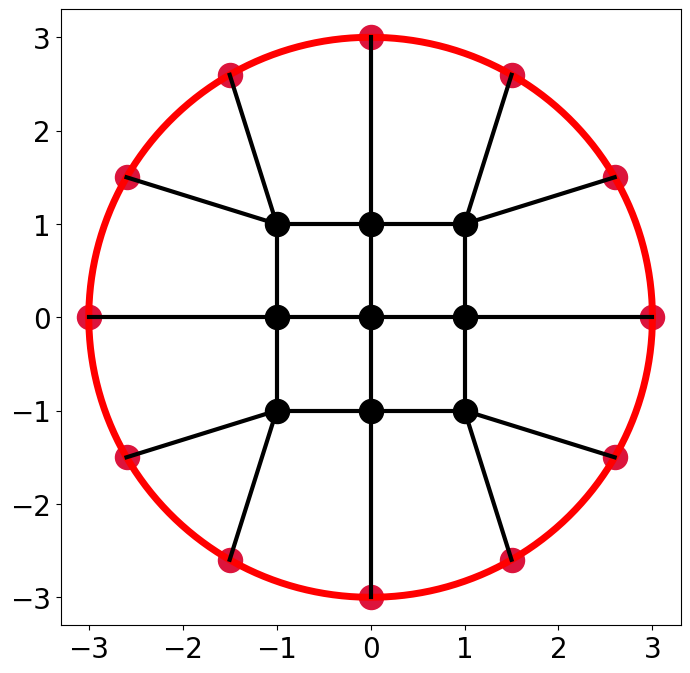

In [6]:
# Draw the initial configuration of the spring system
draw_spring_system(pos,springs,Rhoop,ind_hoop,ind_free)

In [13]:
def compute_gradient(theta,pos,Asymm,r0,kappa,R,ind_hoop,ind_free):
    Nhoop = np.size(ind_hoop)
    g_hoop = np.zeros((Nhoop,)) # gradient with respect to the angles of the hoop nodes
    Nfree = np.size(ind_free)
    g_free = np.zeros((Nfree,2)) # gradient with respect to the x- and y-components of the free nodes
    for k in range(Nhoop):
        ind = np.squeeze(np.nonzero(Asymm[ind_hoop[k],:])) # index of the node adjacent to the kth node on the hoop
        rvec = pos[ind_hoop[k],:] - pos[ind,:] # the vector from that adjacent node to the kth node on the hoop
        rvec_length = np.linalg.norm(rvec) # the length of this vector
        # print(k,ind,ind_hoop[k],rvec)
        g_hoop[k] = (rvec_length - r0)*R*kappa*(rvec[0]*(-np.sin(theta[k])) + rvec[1]*np.cos(theta[k]))/rvec_length
    for k in range(Nfree):
        ind = np.squeeze(np.array(np.nonzero(Asymm[ind_free[k],:]))) # indices of the nodes adjacent to the kth free node
        Nneib = np.size(ind)
        for j in range(Nneib):
            rvec = pos[ind_free[k],:] - pos[ind[j],:] # the vector from the jth adjacent node to the kth free node 
            rvec_length = np.linalg.norm(rvec) # the length of this vector
            g_free[k,:] = g_free[k,:] + (rvec_length - r0)*R*kappa*rvec/rvec_length
    # return a single 1D vector
    return np.concatenate((g_hoop,g_free[:,0],g_free[:,1]))     

def Energy(theta,pos,springs,r0,kappa):
    Nsprings = np.size(springs,axis = 1)
    E = 0.
    for k in range(Nsprings):
        j0 = springs[0,k]
        j1 = springs[1,k]
        rvec = pos[j0,:] - pos[j1,:]
        rvec_length = np.linalg.norm(rvec)        
        E = E + kappa*(rvec_length - r0)**2
    E = E*0.5
    return E
    

In [12]:
def vec_to_pos(vec):
    theta = vec[:Nhoop]
    pos[ind_hoop,0] = Rhoop*np.cos(theta)
    pos[ind_hoop,1] = Rhoop*np.sin(theta)
    # positions of the free nodes
    pos[ind_free,0] = vec[Nhoop:Nnodes]
    pos[ind_free,1] = vec[Nnodes:] 
    return theta,pos

def gradient(vec):
    theta,pos = vec_to_pos(vec) 
    return compute_gradient(theta,pos,Asymm,r0,kappa,Rhoop,ind_hoop,ind_free)

def func(vec):
    theta,pos = vec_to_pos(vec) 
    return Energy(theta,pos,springs,r0,kappa)


In [ ]:
class Adam:
    def __init__(self, initial_vec, object_function, gradient, alpha=0.001, beta_1=0.9, beta_2=0.999, max_iteration=1000, epsilon=1e-8):
        self.vec = initial_vec
        self.vec_set = [initial_vec]
        self.energy_set = [object_function(initial_vec)]
        self.gradient_set = [gradient(initial_vec)]
        
        self.object_function = object_function
        self.gradient = gradient
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.max_iteration = max_iteration
        self.epsilon = epsilon
        
        self.m = 0
        self.v = 0
        self.t = 0
    
    def update(self, vec):
        
        self.t += 1
        g = self.gradient(vec)  # Get gradients w.r.t. stochastic objective at timestep t
        
        self.m = self.beta_1 * self.m + (1 - self.beta_1) * g   # Update biased first moment estimate
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * g**2    # Update biased second raw moment estimate
        
        m_hat = self.m / (1 - self.beta_1**self.t)  # Compute bias-corrected first moment estimate
        v_hat = self.v / (1 - self.beta_2**self.t)  # Compute bias-corrected second raw moment estimate
        
        new_vec = vec - self.alpha * m_hat / (np.sqrt(v_hat) + self.epsilon)    # Update parameters
        
        return new_vec
    
    def kernel(self):
        for i in range(self.max_iteration):
            # optimization step
            self.vec = self.update(self.vec)
            
            # data saving step
            self.vec_set.append(self.vec)
            self.energy_set.append(self.object_function(self.vec))
            self.gradient_set.append(self.gradient(self.vec))

            if i % 10 == 0:
                print(f'iteration {i},\tenergy = {self.energy_set[-1]},\tgradient norm = {np.linalg.norm(self.gradient_set[-1])}')
            
            # check the convergence
            if np.linalg.norm(self.gradient_set[-1]) < 1e-6 and np.abs(self.energy_set[-1] - self.energy_set[-2]) < 1e-6:
                print(f'\nConverged at iteration {i},\tenergy = {self.energy_set[-1]},\tgradient norm = {np.linalg.norm(self.gradient_set[-1])}')
                break

In [27]:
adam_optimizer = Adam(vec, func, gradient)
adam_optimizer.kernel()

iteration 0,	energy = 1.4924963430995586,	gradient norm = 0.05353935344515099
iteration 10,	energy = 1.4924563979223022,	gradient norm = 0.01747473922982127
iteration 20,	energy = 1.4924551686103944,	gradient norm = 0.01533573732883991
iteration 30,	energy = 1.49245210805294,	gradient norm = 0.006440251301327803
iteration 40,	energy = 1.4924514930387627,	gradient norm = 0.0021003596748337856
iteration 50,	energy = 1.4924514312868409,	gradient norm = 0.0011343176900488008
iteration 60,	energy = 1.4924514176596773,	gradient norm = 0.0006710537157568225
iteration 70,	energy = 1.492451418674829,	gradient norm = 0.0008253721574553932
iteration 80,	energy = 1.4924514165832483,	gradient norm = 0.0007677187596436522
iteration 90,	energy = 1.4924514097523354,	gradient norm = 0.0003342169429581576
iteration 100,	energy = 1.4924514081178213,	gradient norm = 0.0001061643356380274
iteration 110,	energy = 1.4924514083646139,	gradient norm = 0.0001573418501216605
iteration 120,	energy = 1.49245140795

In [49]:
class BFGS:
    def __init__(self, initial_vec, object_function, gradient, max_iteration=1000):
        self.vec = initial_vec
        self.vec_set = [initial_vec]
        self.energy_set = [object_function(initial_vec)]
        self.gradient_set = [gradient(initial_vec)]
        
        self.object_function = object_function
        self.gradient = gradient
        self.max_iteration = max_iteration
        
        self.H = np.eye(len(initial_vec))
    
    def update(self, vec):
        g = self.gradient(vec)
        s = -np.dot(self.H, g)
        new_vec = vec + s
        y = self.gradient(new_vec) - g
        rho = 1 / np.dot(y, s)
        I = np.eye(len(vec))
        Hess = np.dot(np.dot(I - rho * np.outer(s, y), self.H), I - rho * np.outer(y, s)) + rho * np.outer(s, s)
        
        return new_vec, Hess
    
    def kernel(self):
        for i in range(self.max_iteration):
            # optimization step
            self.vec, self.H = self.update(self.vec)
            
            # data saving step
            self.vec_set.append(self.vec)
            self.energy_set.append(self.object_function(self.vec))
            self.gradient_set.append(self.gradient(self.vec))

            if i % 10 == 0:
                print(f'iteration {i},\tenergy = {self.energy_set[-1]},\tgradient norm = {np.linalg.norm(self.gradient_set[-1])}')
            
            # check the convergence
            if np.linalg.norm(self.gradient_set[-1]) < 1e-6 and np.abs(self.energy_set[-1] - self.energy_set[-2]) < 1e-6:
                print(f'\nConverged at iteration {i},\tenergy = {self.energy_set[-1]},\tgradient norm = {np.linalg.norm(self.gradient_set[-1])}')
                break

bfgs_optimizer = BFGS(vec, func, gradient)
bfgs_optimizer.kernel()

iteration 0,	energy = 1.4924515734521575,	gradient norm = 0.0034255083749786803
iteration 10,	energy = 1.4924535226137485,	gradient norm = 0.012205240295814108
iteration 20,	energy = 1.4924523528816562,	gradient norm = 0.006797005016729495
iteration 30,	energy = 1.4924514079579012,	gradient norm = 9.383519894874933e-06

Converged at iteration 31,	energy = 1.4924514079508941,	gradient norm = 3.8268520084642785e-07


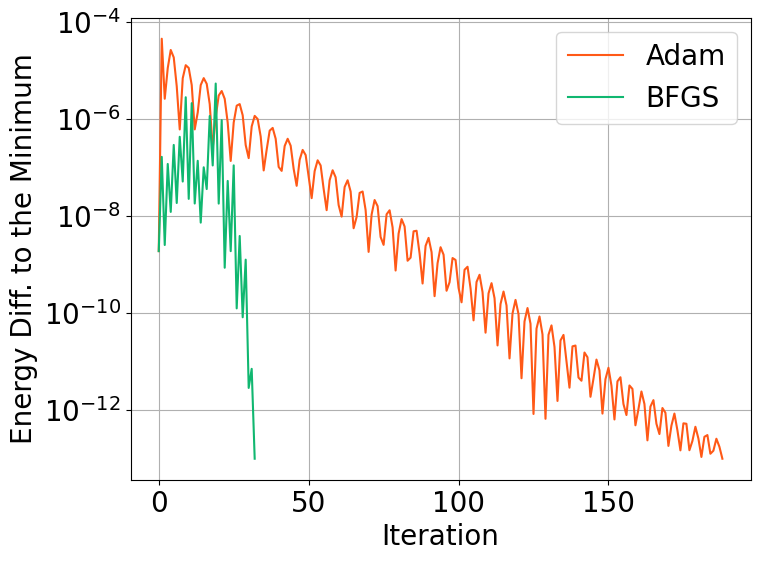

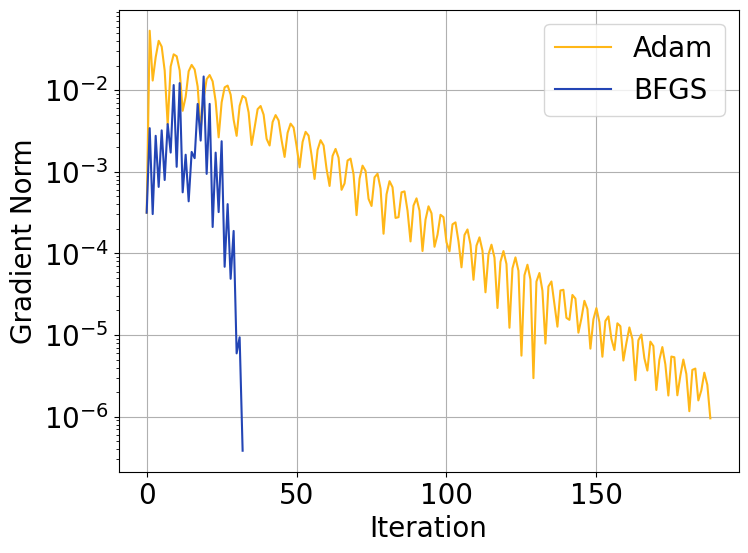

In [87]:
# plot the optimization process, energy vs iteration and gradient norm vs iteration with better colors
plt.figure(figsize=(8, 6))
plt.plot(adam_optimizer.energy_set - adam_optimizer.energy_set[-1] + 1e-13, color='#FF5917', label='Adam')
plt.plot(bfgs_optimizer.energy_set - bfgs_optimizer.energy_set[-1] + 1e-13, color='#10B770', label='BFGS')
plt.xlabel('Iteration')
plt.ylabel('Energy Diff. to the Minimum')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot([np.linalg.norm(g) for g in adam_optimizer.gradient_set], color='#FFB717', label='Adam')
plt.plot([np.linalg.norm(g) for g in bfgs_optimizer.gradient_set], color='#2345B5', label='BFGS')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

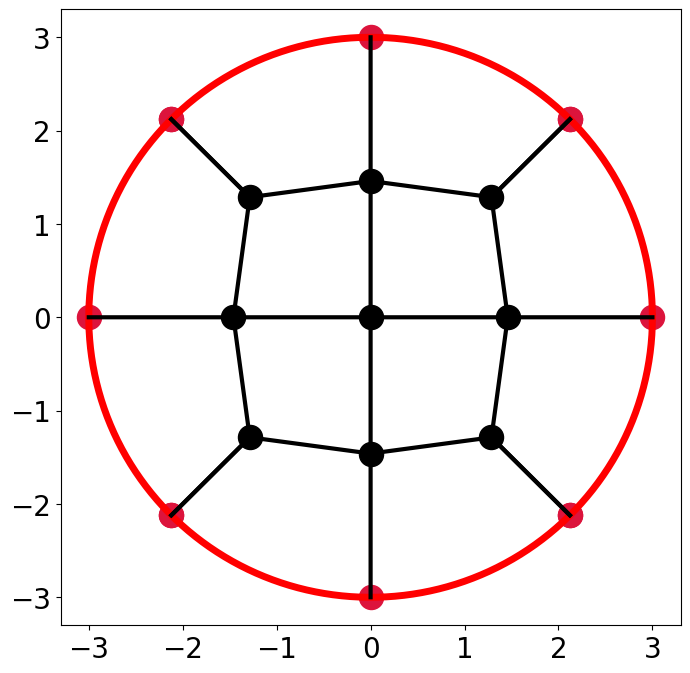

In [88]:
# plot the final Adam result
theta,pos = vec_to_pos(adam_optimizer.vec_set[-1])
draw_spring_system(pos,springs,Rhoop,ind_hoop,ind_free)
plt.show()

In [90]:
adam_optimizer.vec_set[-1]

array([ 2.35620361e+00,  2.35620361e+00,  3.14160181e+00,  3.92699997e+00,
        3.92699997e+00,  4.71239814e+00,  5.49779626e+00,  5.49779626e+00,
        6.28319443e+00,  7.06859261e+00,  7.06859261e+00,  7.85399076e+00,
       -1.28645217e+00, -1.33638781e-05,  1.28642868e+00, -1.46011555e+00,
        2.46565698e-08,  1.46011550e+00, -1.28642865e+00,  1.33410256e-05,
        1.28645215e+00,  1.28642866e+00,  1.46011557e+00,  1.28645212e+00,
       -1.33433862e-05, -2.12707531e-08,  1.33654632e-05, -1.28645215e+00,
       -1.46011553e+00, -1.28642863e+00])

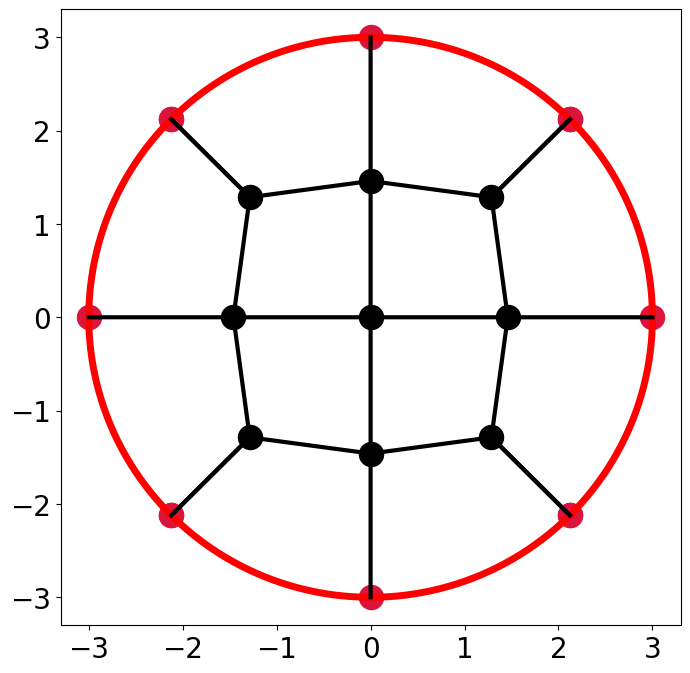

In [ ]:
# plot the final BFGS result
theta,pos = vec_to_pos(bfgs_optimizer.vec_set[-1])
draw_spring_system(pos,springs,Rhoop,ind_hoop,ind_free)
plt.show()

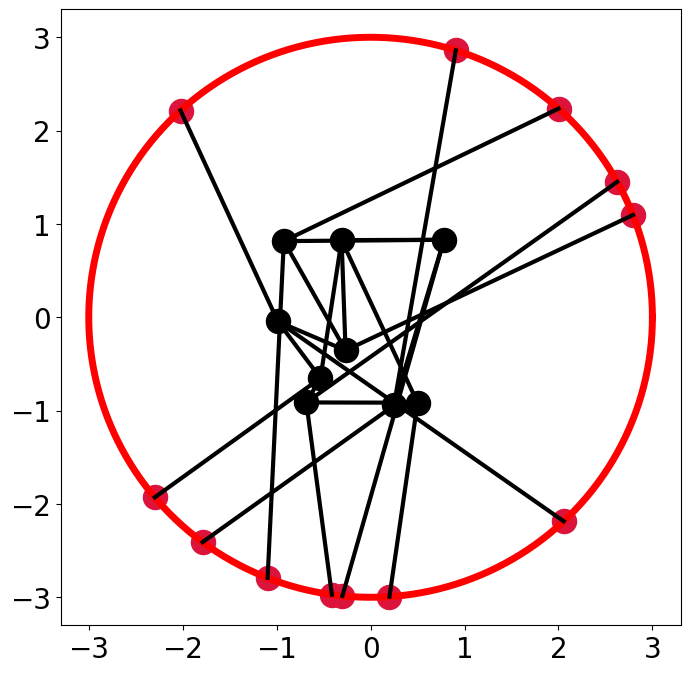

In [70]:
random_theta = np.random.rand(Nhoop) * 2 * np.pi
random_pos = np.random.rand(Nfree, 2) * 2 - 1
random_vec = np.concatenate((random_theta, random_pos[:, 0], random_pos[:, 1]))

# plot the initial random configuration
theta, pos = vec_to_pos(random_vec)
draw_spring_system(pos, springs, Rhoop, ind_hoop, ind_free)
plt.show()


iteration 0,	energy = 31.592471090691994,	gradient norm = 22.606987980747483
iteration 10,	energy = 31.198861029963584,	gradient norm = 22.279832994001346
iteration 20,	energy = 30.81388391894398,	gradient norm = 21.960717028717404
iteration 30,	energy = 30.437476659092685,	gradient norm = 21.65550384732429
iteration 40,	energy = 30.069113537438053,	gradient norm = 21.362242978640353
iteration 50,	energy = 29.708761564387295,	gradient norm = 21.07500779702901
iteration 60,	energy = 29.356447828770303,	gradient norm = 20.791362044183767
iteration 70,	energy = 29.01192926775474,	gradient norm = 20.512267425498738
iteration 80,	energy = 28.674779594638917,	gradient norm = 20.239666013348888
iteration 90,	energy = 28.34454836711499,	gradient norm = 19.975225726964812
iteration 100,	energy = 28.020837762437733,	gradient norm = 19.7199178591322
iteration 110,	energy = 27.703303948364095,	gradient norm = 19.47398273748672
iteration 120,	energy = 27.391634998731178,	gradient norm = 19.23719158

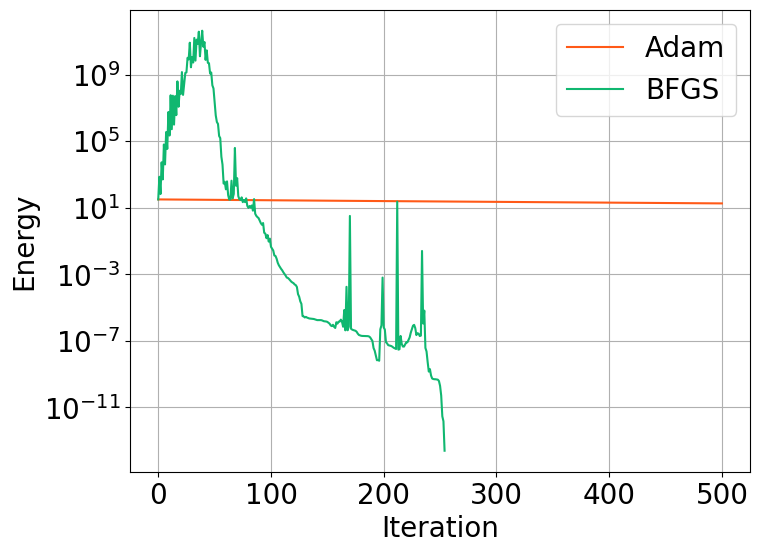

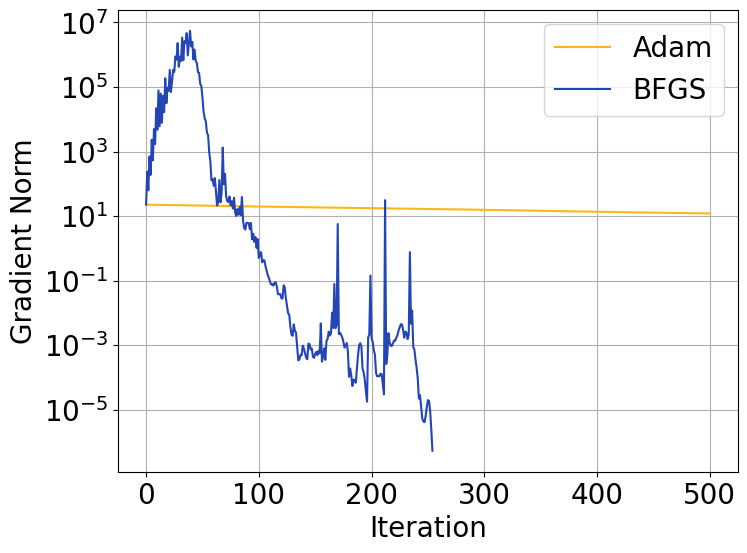

In [94]:
random_adam_optimizer = Adam(random_vec, func, gradient, max_iteration=500)
random_adam_optimizer.kernel()

random_bfgs_optimizer = BFGS(random_vec, func, gradient, max_iteration=500)
random_bfgs_optimizer.kernel()

# plot the optimization process, energy vs iteration and gradient norm vs iteration with better colors
plt.figure(figsize=(8, 6))
plt.plot(random_adam_optimizer.energy_set, color='#FF5917', label='Adam')
plt.plot(random_bfgs_optimizer.energy_set, color='#10B770', label='BFGS')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot([np.linalg.norm(g) for g in random_adam_optimizer.gradient_set], color='#FFB717', label='Adam')
plt.plot([np.linalg.norm(g) for g in random_bfgs_optimizer.gradient_set], color='#2345B5', label='BFGS')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

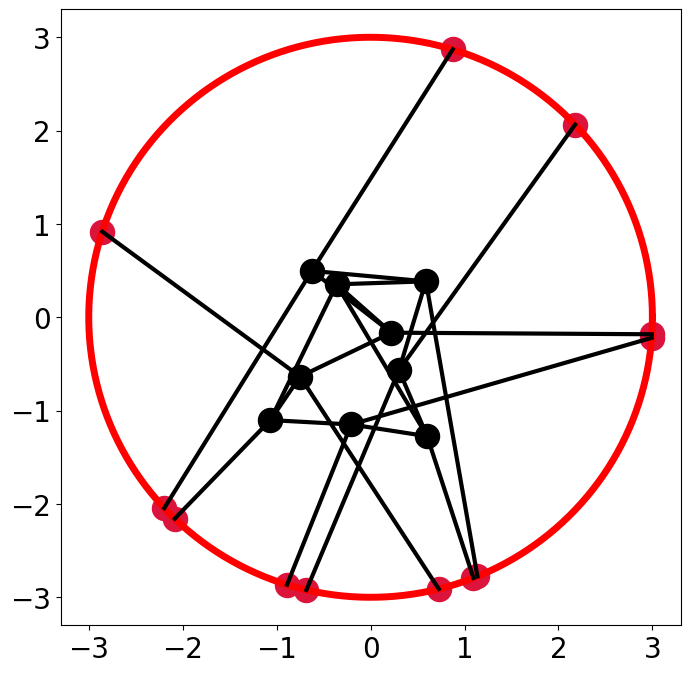

In [95]:
# plot the final Adam result
theta,pos = vec_to_pos(random_adam_optimizer.vec_set[-1])
draw_spring_system(pos,springs,Rhoop,ind_hoop,ind_free)
plt.show()

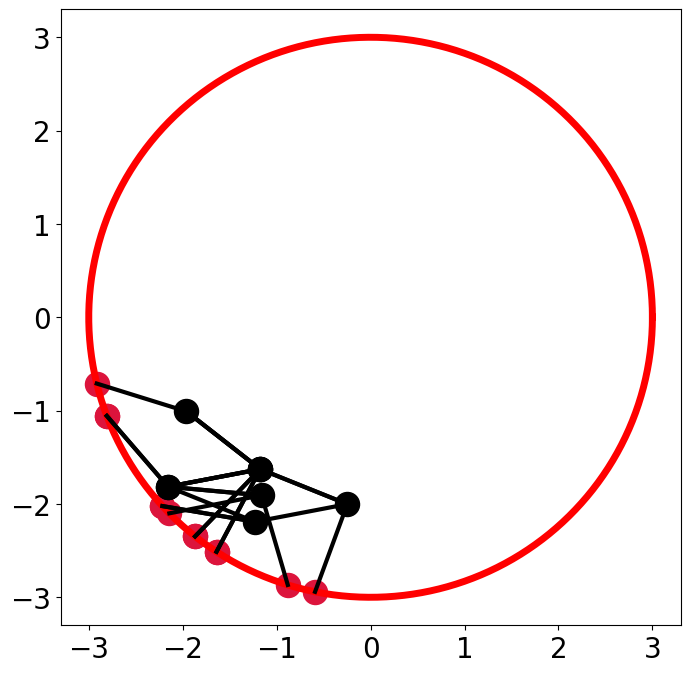

In [96]:
# plot the final Adam result
theta,pos = vec_to_pos(random_bfgs_optimizer.vec_set[-1])
draw_spring_system(pos,springs,Rhoop,ind_hoop,ind_free)
plt.show()